## Imports

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import animation as animation
from itertools import product
from tqdm.notebook import tqdm

## Simulation Model

In [11]:
class Tree(object):
    def __init__(self, tree_type = "tree1", STATE = None, BT = 25, GT = 50):
        self.tree_type = tree_type
        self.STATE = STATE
        if tree_type == "tree1":
            self.BURN_TIME = BT
            self.GROW_TIME = GT
        elif tree_type == "tree2":
            self.BURN_TIME = BT
            self.GROW_TIME = GT
        else:
            print("Enter valid tree type: tree1/tree2")
        self.BURN_TIMER = 0
        self.GROW_TIMER = 0

class simulateStochasticFire():
    def __init__(self, 
                N,
                tree1_dist = 0.5,
                tree1_BURN_TIME = 2,
                tree1_GROW_TIME = 5,
                tree2_BURN_TIME = 10,
                tree2_GROW_TIME = 15,
                FIRE_SPREAD_PROB = .5,
                BURNOUT_PROB = .6,
                SELF_RECOVERY_PROB =.03,
                NEIGHBOR_RECOVERY_PROB = .1,
                COMPLETE_RECOVERY_PROB = .05,
                WATER_FRACTION = 0.1,
                WATER_RESOURCE = 0.01,
                IC_MODE = 1,
                experiment = True,
                ):
        random.seed(0)

        self.N = N 
        self.tree_cmap = {
                    "tree1": 
                            {
                                "INERT" : (0, 255, 0), # Green can be ignited
                                "BURNING" : (255, 0, 0), #Red # BURNING is burning 
                                "BURNT" : (105, 105, 105), #Black # burnt is not actively recovering
                                "RECOVERING": (255, 255, 0), # Yellow # is recovering 
                                "WATERED" : (0, 0, 255), # Blue #watering the cell                     
                            },
                    "tree2":
                            {
                                "INERT" : (76, 187, 23), # Dark Green can be ignited
                                "BURNING" : (220, 20, 60), #Dark Red # BURNING is burning 
                                "BURNT" : (0,0,0), #Grey # burnt is not actively recovering
                                "RECOVERING": (246,190,0), # Dark Yellow # is recovering 
                                "WATERED" : (0, 0, 255), # Blue #watering the cell
                            }
                    
                    }

        for tree_type in self.tree_cmap:
            for STATE in self.tree_cmap[tree_type]:
                self.tree_cmap[tree_type][STATE] = np.array(self.tree_cmap[tree_type][STATE])

        self.WATER_FRACTION = WATER_FRACTION
        self.WATER_RESOURCE = WATER_RESOURCE

        self.FIRE_SPREAD_PROB = FIRE_SPREAD_PROB
        self.BURNOUT_PROB = BURNOUT_PROB
        self.SELF_RECOVERY_PROB = SELF_RECOVERY_PROB
        self.NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB
        self.COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB

        self.IC_MODE = IC_MODE

        self.experiment = experiment

        self.burn_proportion = []
        self.burnt_proportion = []
        self.burnt_region = np.zeros((self.N, self.N))

        self.tree1_dist = tree1_dist
        self.tree2_dist = 1 - self.tree1_dist

        self.ntree = self.N*self.N
        self.ntree1 = int(self.tree1_dist*self.ntree)
        self.ntree2 = int(self.tree2_dist*self.ntree)
        self.cells = np.zeros((self.N, self.N), dtype = object)

        x_idxs, y_idxs = np.array(range(self.N)), np.array(range(self.N))
        xy_pairs = np.array(list(product(x_idxs, y_idxs)))
        np.random.shuffle(xy_pairs)

        tree1_idxs = xy_pairs[0:self.ntree1]
        tree2_idxs = xy_pairs[self.ntree1:]

        for x, y in tree1_idxs:
            self.cells[x, y] = Tree(tree_type="tree1", STATE="INERT", BT = tree1_BURN_TIME, GT = tree1_GROW_TIME)
        for x, y in tree2_idxs:
            self.cells[x, y] = Tree(tree_type="tree2", STATE="INERT", BT = tree2_BURN_TIME, GT = tree2_GROW_TIME)
        
        self.init_fire()

        self.adj_dict = {}
        for x in range(self.N):
            for y in range(self.N):
                self.adj_dict[(x,y)] = [(x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
                                (x, y - 1), (x, y + 1),
                                (x + 1, y - 1), (x + 1, y), (x + 1, y + 1)]
        
        if not self.experiment:
            self.fig, self.ax = plt.subplots(figsize = (6,6))
            forest_grid = self.get_state_grid()
            self.img = self.ax.imshow(forest_grid.astype(int))

    def init_fire(self):
        if self.IC_MODE == 1:
          #Mode 1: Fire cluster in the top left corner
          for x in range(1, self.N//10):
              for y in range(1, self.N//10):
                  self.cells[x, y].STATE = "BURNING"
        elif self.IC_MODE == 2:
          #Mode 2: Fire cluster in the middle
          for x in range(int(4.5 * self.N//10), int(5.5 * self.N//10)):
              for y in range(int(4.5 * self.N//10), int(5.5 * self.N//10)):
                self.cells[x, y].STATE = "BURNING"
        elif self.IC_MODE == 3:
          #Mode 3: Fire cluster in the bottom right corner
          for x in range(9 * self.N//10, self.N):
              for y in range(9 * self.N//10, self.N):
                self.cells[x, y].STATE = "BURNING"
          #Mode 4: Fire cluster in 2 corners
        elif self.IC_MODE == 4:
          for x in range(1, self.N//10):
            for y in range(1, self.N//10):
              self.cells[x, y].STATE = "BURNING"
          for x in range(9*self.N//10, self.N):
            for y in range(9*self.N//10, self.N):
              self.cells[x, y].STATE = "BURNING"
          

    def run_one_step(self, data):
        newGrid = copy.deepcopy(self.cells)#.copy()
        for x in range(1, self.N - 1):
            for y in range(1, self.N - 1):
                curr_cell = self.cells[x,y]
                curr_state = curr_cell.STATE

                if curr_state == "BURNING":
                    for neighbor in self.adj_dict[(x, y)]:
                        if self.cells[neighbor].STATE == "INERT" and random.random() < self.FIRE_SPREAD_PROB:
                            newGrid[neighbor].STATE = "BURNING"
                    if (self.cells[x, y].BURN_TIMER > self.cells[x, y].BURN_TIME) and (random.random() < self.BURNOUT_PROB):
                        newGrid[x, y].STATE = "BURNT"
                        newGrid[x, y].BURN_TIMER = 0
                    else:
                        newGrid[x, y].BURN_TIMER = self.cells[x,y].BURN_TIMER + 1
                elif curr_state == "BURNT" and random.random() < self.SELF_RECOVERY_PROB:
                    newGrid[x, y].STATE = "RECOVERING"
                elif curr_state == "RECOVERING":
                    for neighbor in self.adj_dict[(x, y)]:
                        if self.cells[neighbor].STATE == "BURNT" and (random.random() < self.NEIGHBOR_RECOVERY_PROB):
                            newGrid[neighbor].STATE = "RECOVERING"
                    if (random.random() < self.COMPLETE_RECOVERY_PROB) and (self.cells[x, y].GROW_TIMER > self.cells[x, y].GROW_TIME):
                        newGrid[x, y].STATE = "INERT"
                        newGrid[x, y].GROW_TIMER = 0
                    else:
                        newGrid[x, y].GROW_TIMER = self.cells[x,y].GROW_TIMER + 1
                elif curr_state == "WATERED":
                    newGrid[x, y].STATE = "RECOVERING"

        currently_burning = []
        watering = []
        for x in range(N):
            for y in range(N):
                if newGrid[x, y].STATE == "BURNING":
                    currently_burning.append((x,y))
                    self.burnt_region[x,y] = 1
        
        if currently_burning:
            watering = np.random.choice(range(len(currently_burning)), size = min(self.WATER_RESOURCE*self.N*self.N, int(self.WATER_FRACTION*len(currently_burning))), replace = False)
        
        for w in watering:
            newGrid[currently_burning[w]].STATE = "WATERED"
      
        self.burn_proportion.append(len(currently_burning)/(self.N*self.N))
        self.burnt_proportion.append(np.sum(self.burnt_region)/(self.N*self.N))

        self.cells = newGrid

        if not self.experiment:
            forest_grid = self.get_state_grid()
            self.img.set_array(forest_grid.astype(int))

            return [self.img]
        
    
    def run(self, T, plot_steps = [35, 75]):
        pseudo_argument = T
        for t in tqdm(range(T)):
            if t in plot_steps:
                self.plot_forest(t)
            self.run_one_step(pseudo_argument)
    
    def get_state_grid(self):
        grid = np.zeros((self.N, self.N, 3), dtype=int)
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                grid[x,y,:] = self.tree_cmap[self.cells[x,y].tree_type][self.cells[x,y].STATE]
        return grid

    def plot_forest(self, T):
        grid = self.get_state_grid()
        plt.figure()
        plt.imshow(grid)
        print()
        plt.title(f"Iteration = {T}")
        plt.show()
    
    def animate_forest(self, T=20):
        ani = animation.FuncAnimation(self.fig, self.run_one_step, interval=T,save_count=T)
        ani.save('myanimation.gif')
        return ani

## Execution cell

  0%|          | 0/100 [00:00<?, ?it/s]

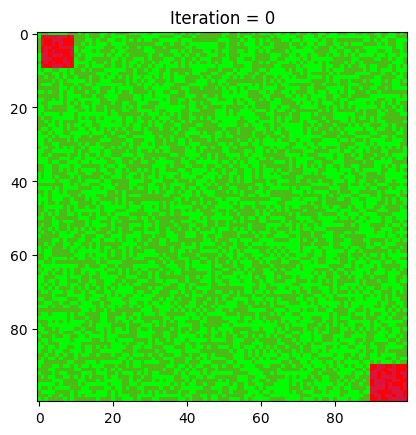

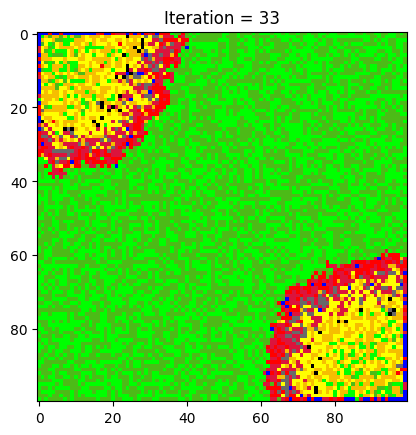

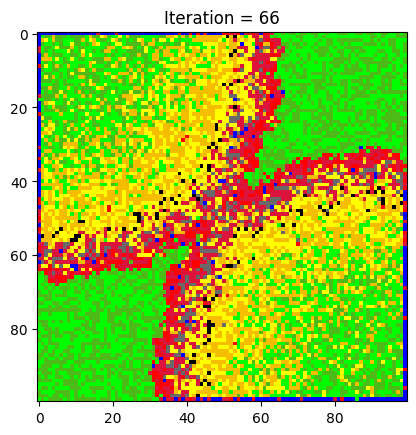

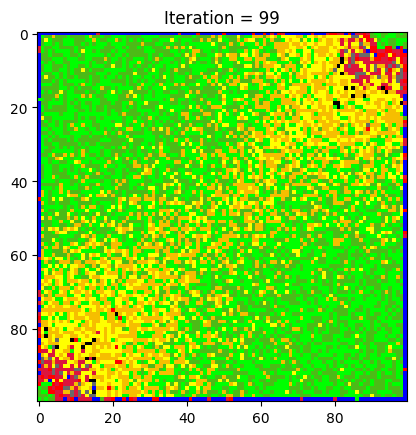

In [13]:
#Play around with these numbers and see what happens!

N = 100 #Grid size = N*N
T = 100 #Number of iterations

tree1_dist = 0.5 #Proportion of cells filled with type 1 tree, 1-tree1_dist  = tree2_dist

FIRE_SPREAD_PROB = 0.3 #Probability of a neighbour of a burning cell catching fire
BURNOUT_PROB = 0.6 #Probability of a burning cell becoming burnt
SELF_RECOVERY_PROB = 0.03 #Probability of a burnt cell starting recovery
NEIGHBOR_RECOVERY_PROB = 0.1 #Probability of a burnt neighbour of another recovering cell starting recovery
COMPLETE_RECOVERY_PROB = 0.05 #Probability of a recovering cell recovering completely, to become an inert cell

WATER_FRACTION = 0.04 #Fraction of the burning cells chosen to be watered
WATER_RESOURCE = 0.02 #Maximum possible water resources, as a fraction of forest size. 
#For eg, WATER_RESOURCE = 0.02 means available water resources are sufficient to water 2% of the entire forest, or 0.02*N*N cells.

IC_MODE = 4
#1: Fire Cluster in top left corner, 2: Fire Cluster in the center, 3: Fire Cluster in the bottom right corner, 4: Fire Cluster in both corners

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

### Experiment 1: Fire in the center

  0%|          | 0/100 [00:00<?, ?it/s]

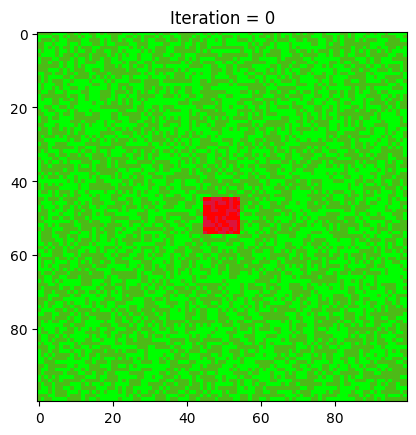

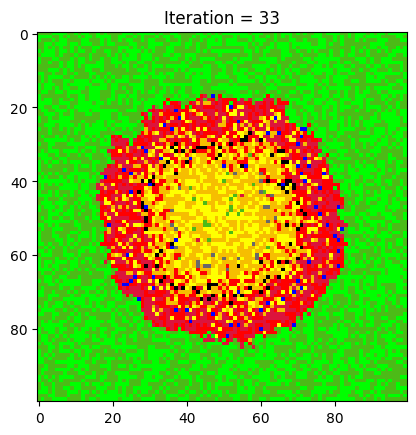

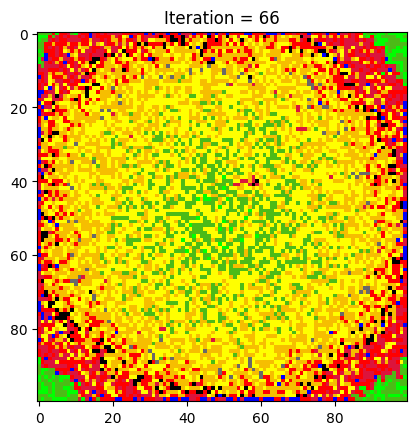

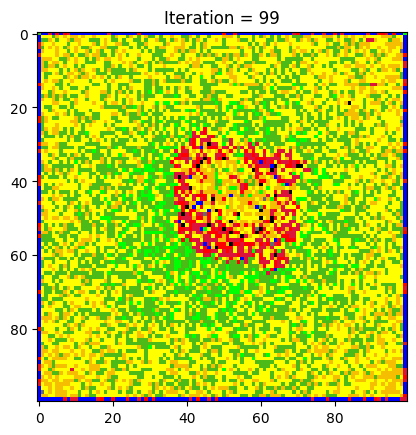

In [ ]:

N = 100
T = 100

tree1_dist = 0.5

FIRE_SPREAD_PROB = 0.3
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

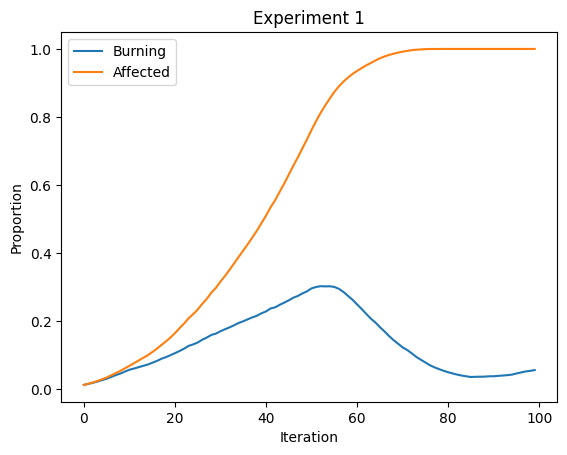

In [ ]:
plt.plot(sim.burn_proportion)
plt.plot(sim.burnt_proportion)
plt.title("Experiment 1")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.legend(["Burning", "Affected"])

### Experiment 2: Fire in a corner

  0%|          | 0/100 [00:00<?, ?it/s]

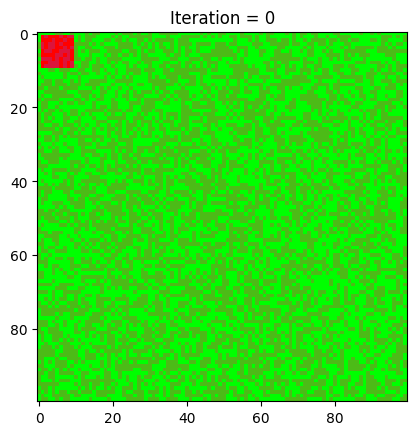

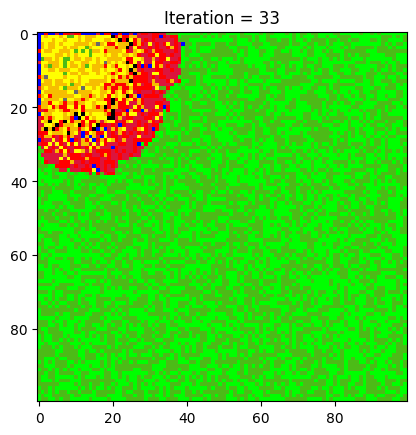

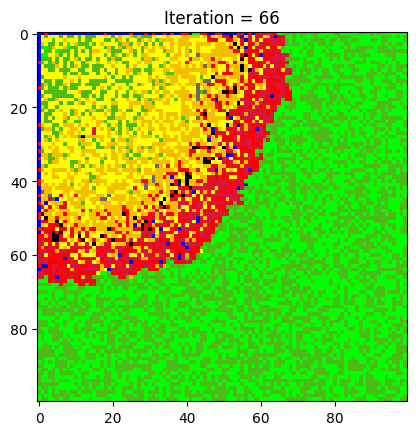

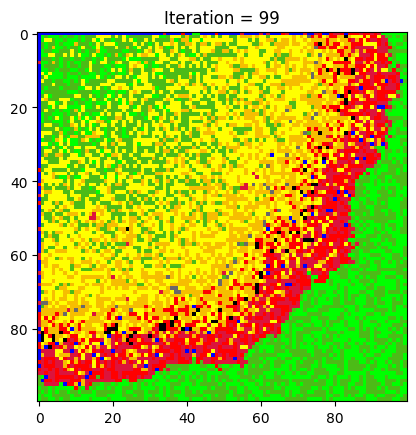

In [ ]:
N = 100
T = 100

tree1_dist = 0.5

FIRE_SPREAD_PROB = 0.3
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 1

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

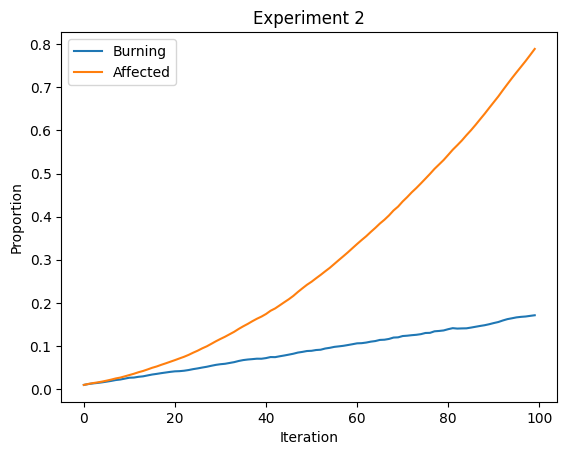

In [ ]:
plt.plot(sim.burn_proportion)
plt.plot(sim.burnt_proportion)
plt.title("Experiment 2")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.legend(["Burning", "Affected"])

### Experiment 3: Fire in two corners

  0%|          | 0/100 [00:00<?, ?it/s]

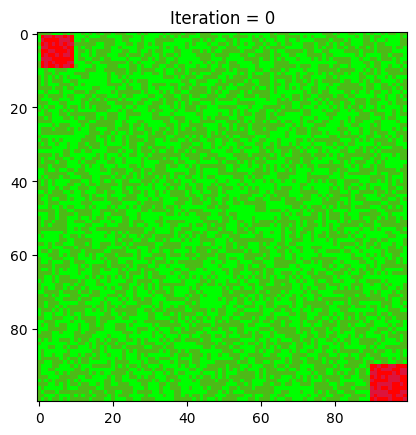

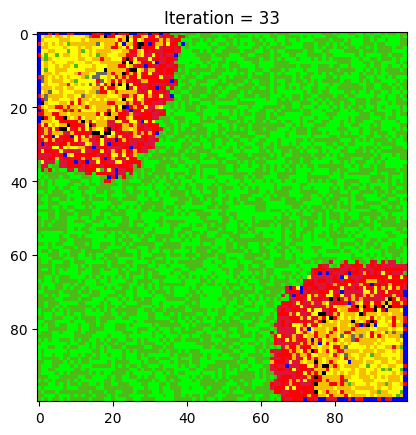

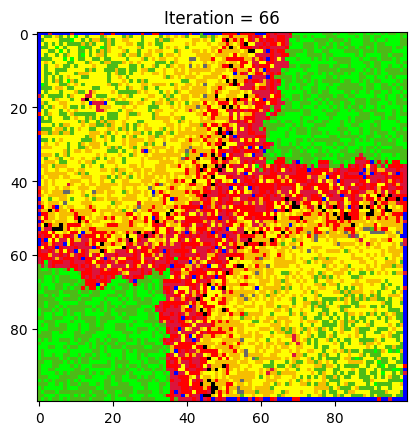

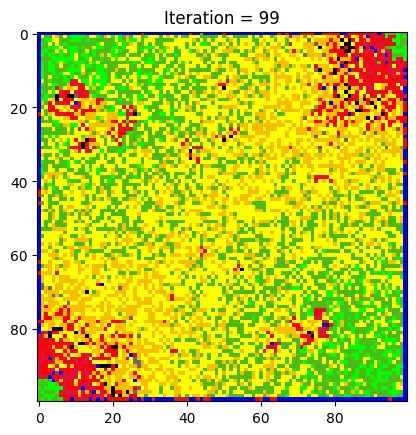

In [ ]:
N = 100
T = 100

tree1_dist = 0.5

FIRE_SPREAD_PROB = 0.3
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 4

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

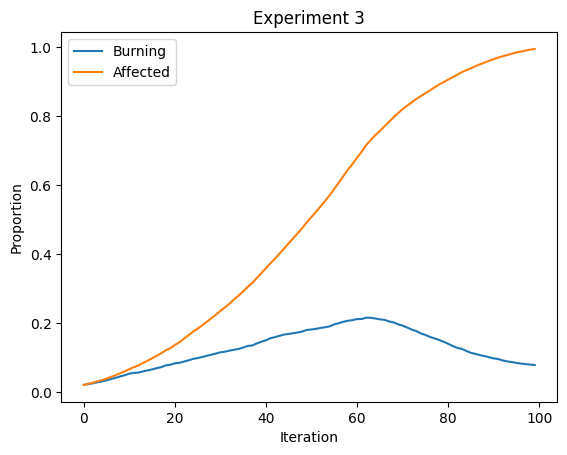

In [ ]:
plt.plot(sim.burn_proportion)
plt.plot(sim.burnt_proportion)
plt.title("Experiment 3")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.legend(["Burning", "Affected"])

### Experiment 4: High fire spread probability, with watering

  0%|          | 0/100 [00:00<?, ?it/s]

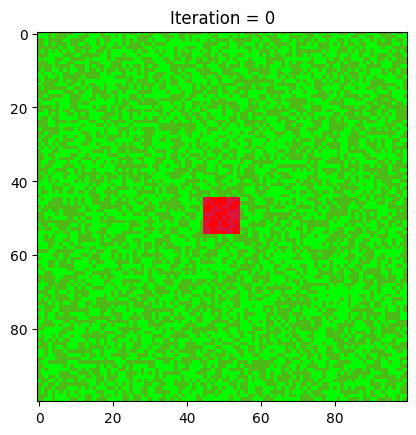

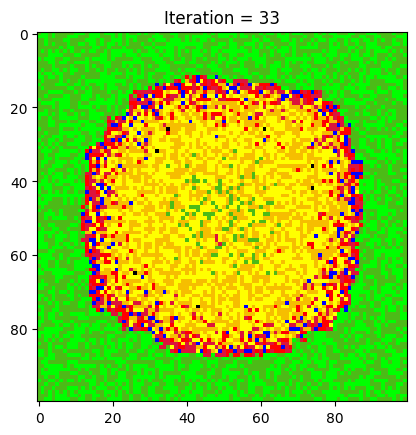

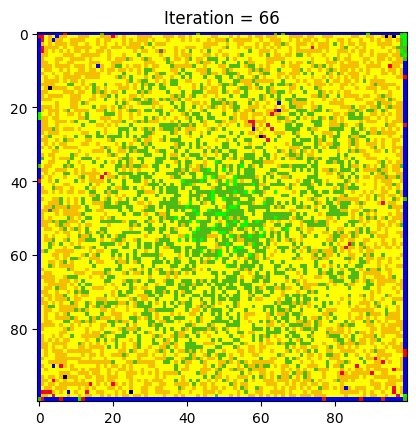

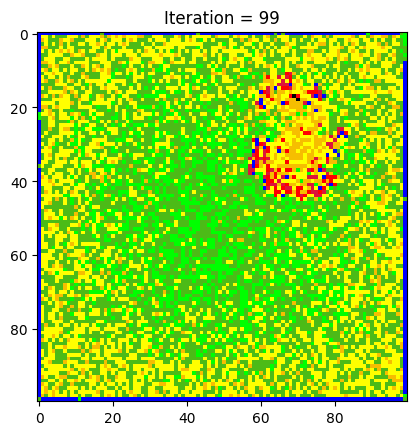

In [ ]:
N = 100
T = 100

tree1_dist = 0.5

FIRE_SPREAD_PROB = 0.6
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.20
WATER_RESOURCE = 0.50

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

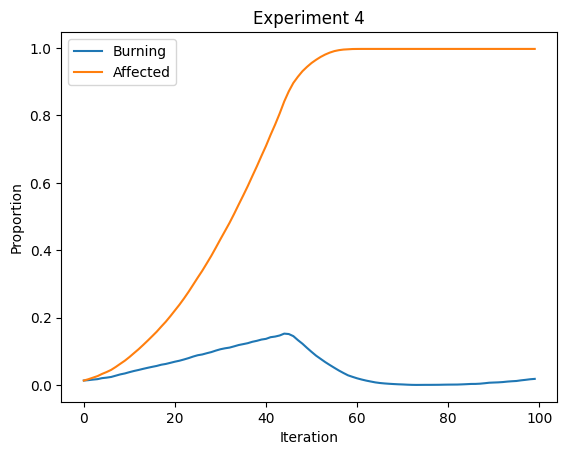

In [ ]:
plt.plot(sim.burn_proportion)
plt.plot(sim.burnt_proportion)
plt.title("Experiment 4")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.legend(["Burning", "Affected"])

### Experiment 5: High Fire Spread Probability, no watering

  0%|          | 0/100 [00:00<?, ?it/s]

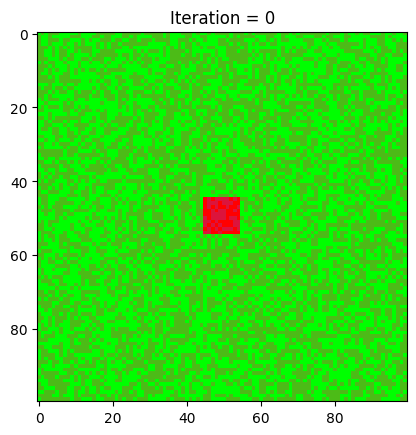

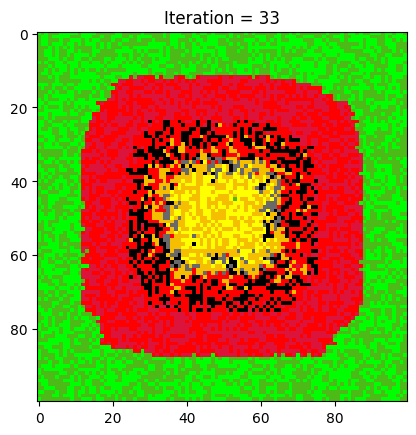

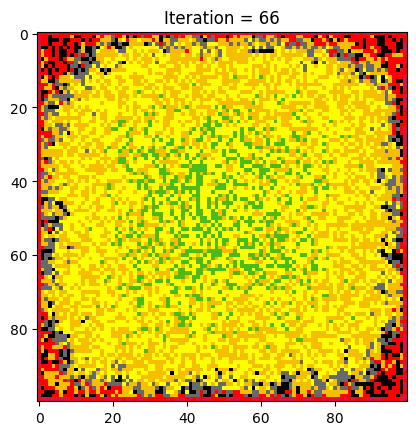

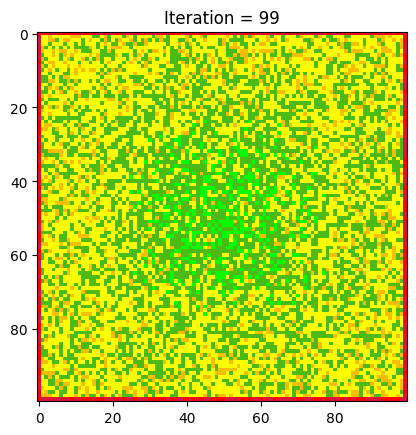

In [ ]:
N = 100
T = 100

tree1_dist = 0.5

FIRE_SPREAD_PROB = 0.6
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.00
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

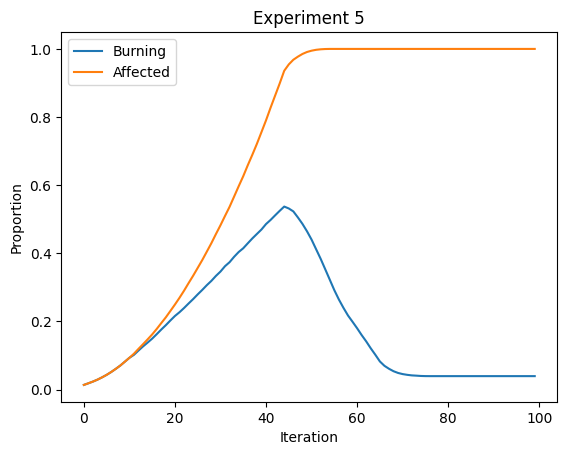

In [ ]:
plt.plot(sim.burn_proportion)
plt.plot(sim.burnt_proportion)
plt.title("Experiment 5")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.legend(["Burning", "Affected"])

### Experiment 6: Low Burn Out Probability

  0%|          | 0/100 [00:00<?, ?it/s]

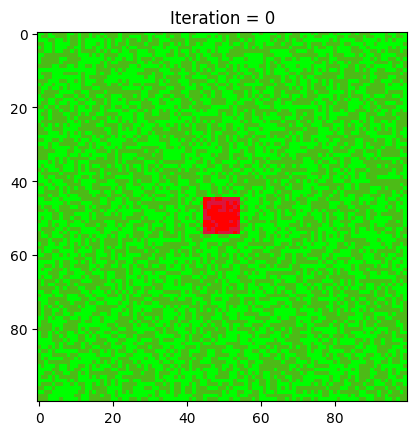

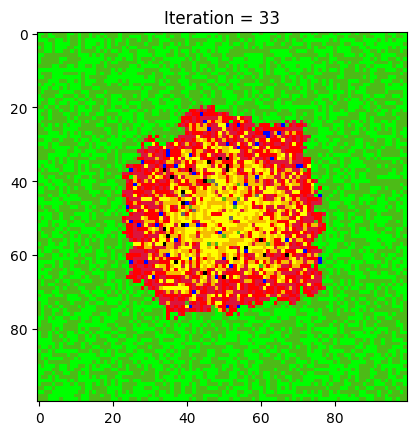

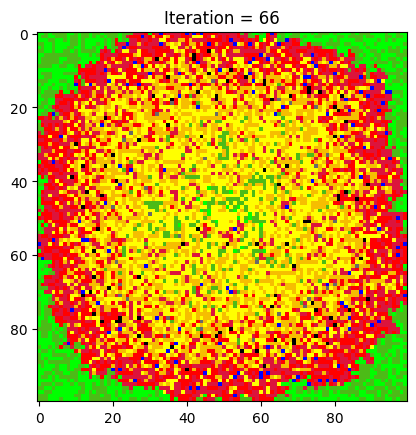

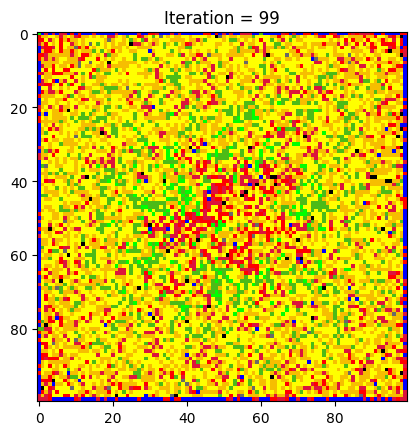

In [ ]:
N = 100
T = 100

tree1_dist = 0.5

FIRE_SPREAD_PROB = 0.2
BURNOUT_PROB = 0.06
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

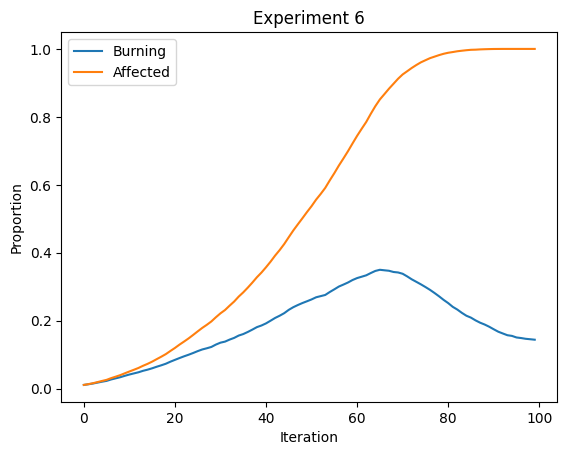

In [ ]:
plt.plot(sim.burn_proportion)
plt.plot(sim.burnt_proportion)
plt.title("Experiment 6")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.legend(["Burning", "Affected"])

### Experiment 7: High Burn Out Probability

  0%|          | 0/100 [00:00<?, ?it/s]

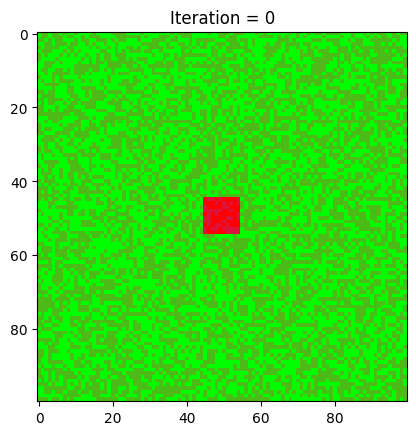

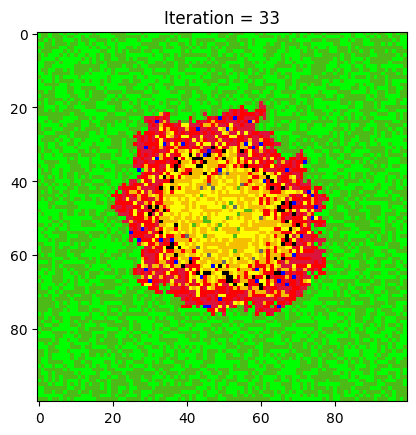

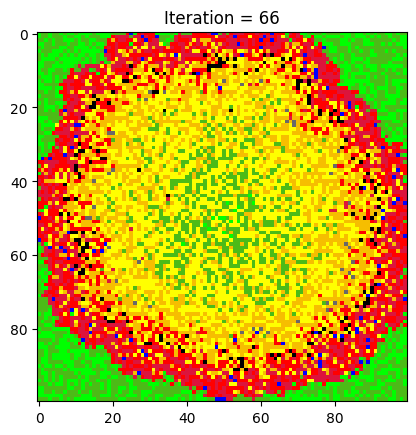

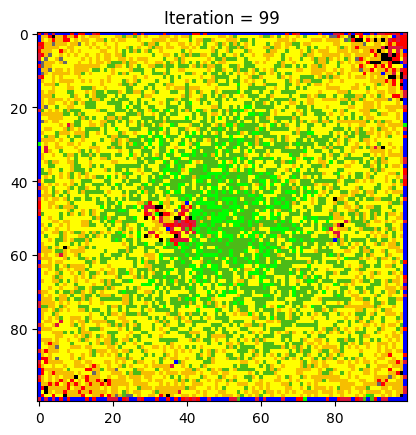

In [ ]:
N = 100
T = 100

tree1_dist = 0.5

FIRE_SPREAD_PROB = 0.2
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

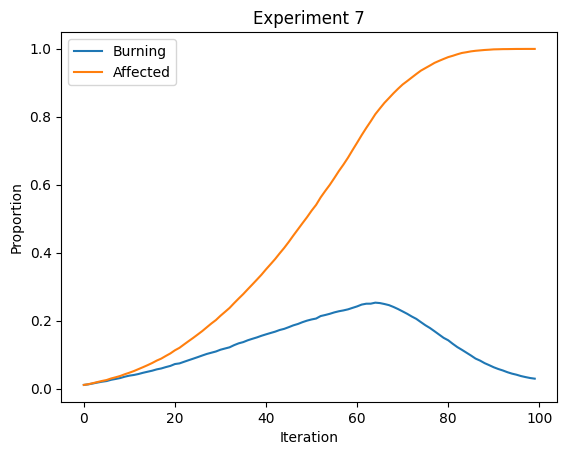

In [ ]:
plt.plot(sim.burn_proportion)
plt.plot(sim.burnt_proportion)
plt.title("Experiment 7")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.legend(["Burning", "Affected"])

### Experiment 8: low complete recovery probability

  0%|          | 0/100 [00:00<?, ?it/s]

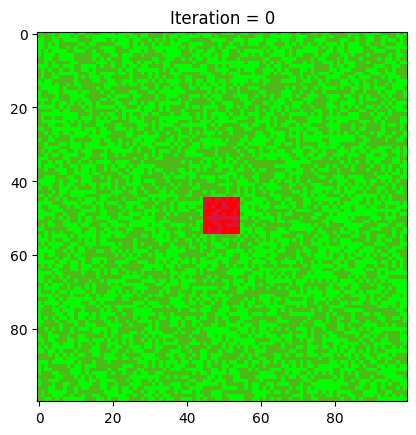

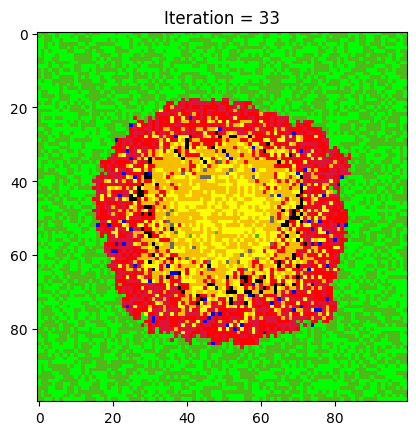

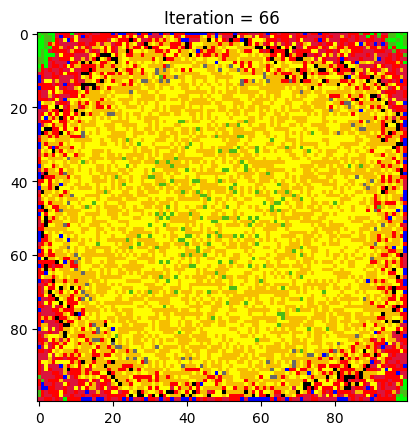

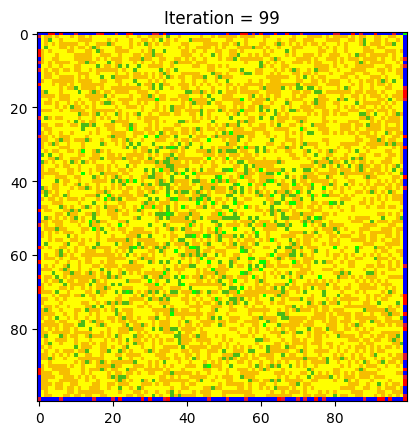

In [ ]:

N = 100
T = 100

tree1_dist = 0.5

FIRE_SPREAD_PROB = 0.3
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.005

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

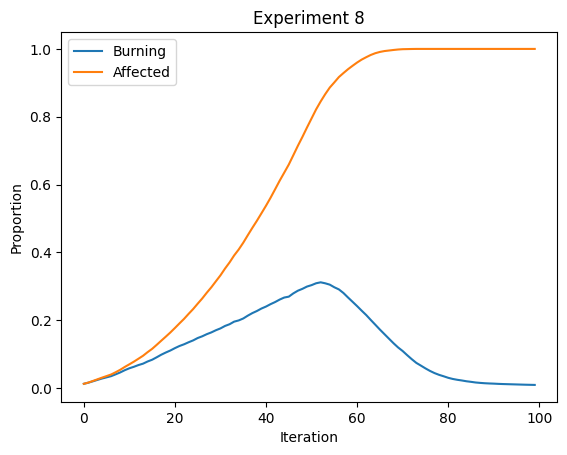

In [ ]:
plt.plot(sim.burn_proportion)
plt.plot(sim.burnt_proportion)
plt.title("Experiment 8")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.legend(["Burning", "Affected"])

### Experiment 9: High complete recovery probability 

  0%|          | 0/100 [00:00<?, ?it/s]

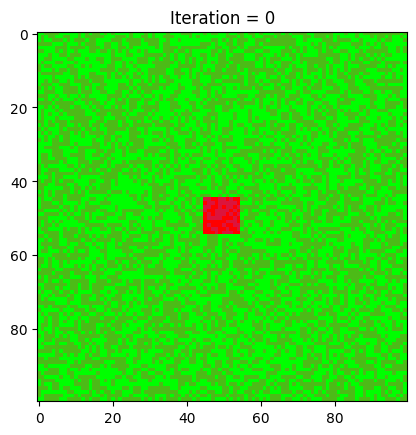

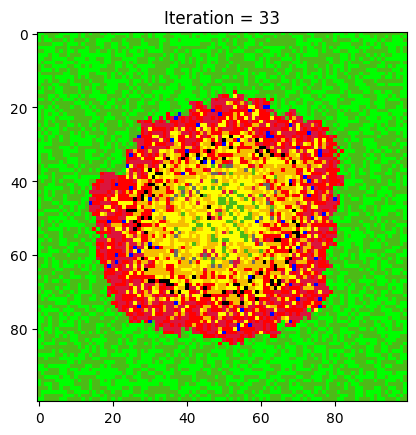

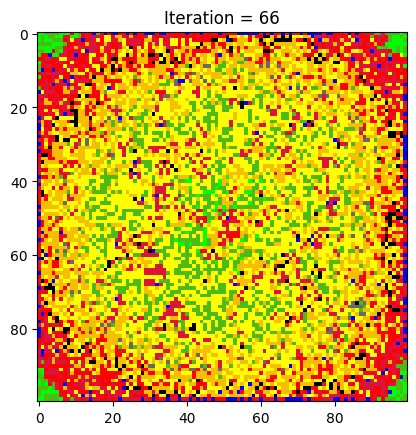

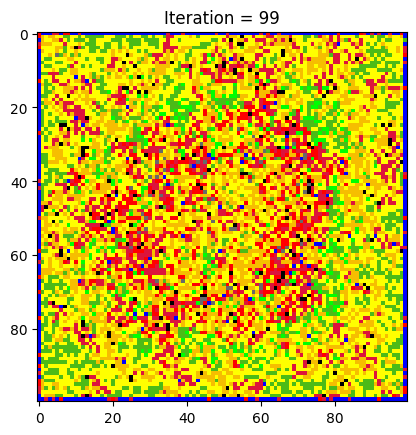

In [ ]:

N = 100
T = 100

tree1_dist = 0.5

FIRE_SPREAD_PROB = 0.3
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.7

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

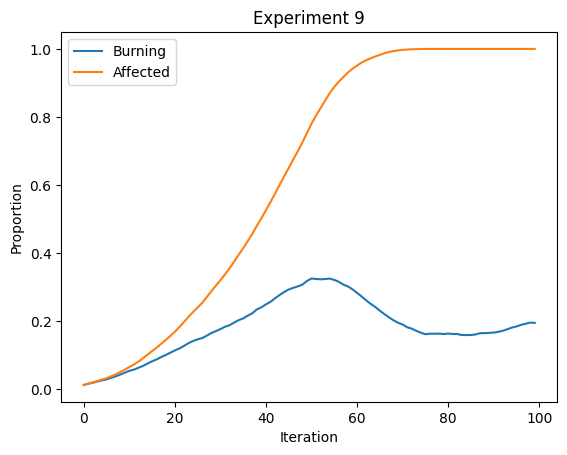

In [ ]:
plt.plot(sim.burn_proportion)
plt.plot(sim.burnt_proportion)
plt.title("Experiment 9")
plt.xlabel("Iteration")
plt.ylabel("Proportion")
plt.legend(["Burning", "Affected"])

### Verification 1: Tree 1 high BT, high GT

  0%|          | 0/100 [00:00<?, ?it/s]

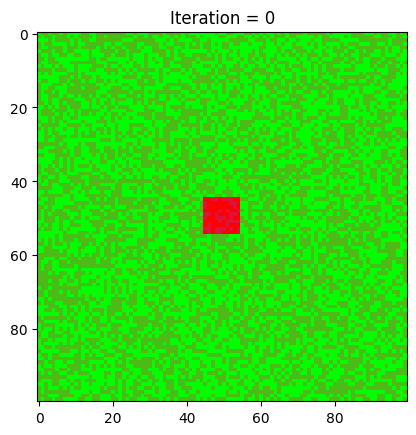

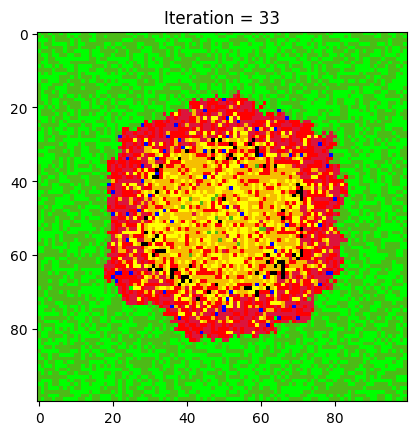

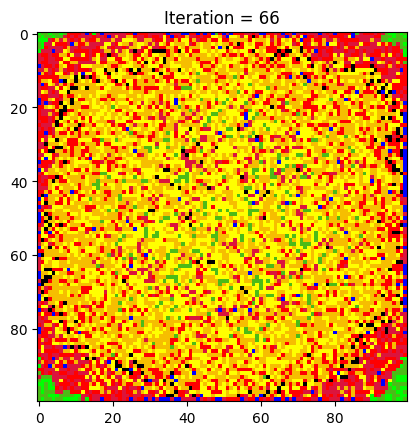

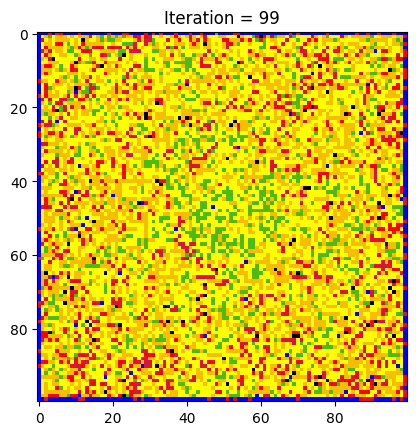

In [ ]:

N = 100
T = 100

tree1_dist = 0.5

tree1_BURN_TIME, tree1_GROW_TIME = T, T
tree2_BURN_TIME, tree2_GROW_TIME = 10, 15

FIRE_SPREAD_PROB = 0.3
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        tree1_BURN_TIME = tree1_BURN_TIME,
        tree1_GROW_TIME = tree1_GROW_TIME,
        tree2_BURN_TIME = tree2_BURN_TIME,
        tree2_GROW_TIME = tree2_GROW_TIME,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

### Verification 2: Tree 1 low BT, low GT

  0%|          | 0/100 [00:00<?, ?it/s]

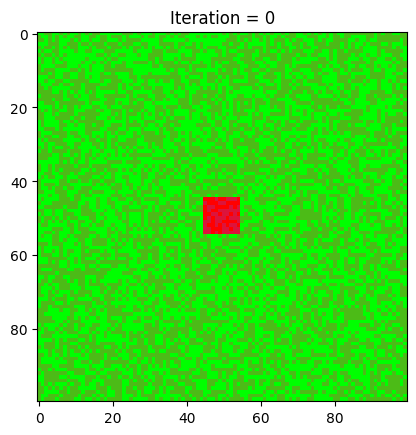

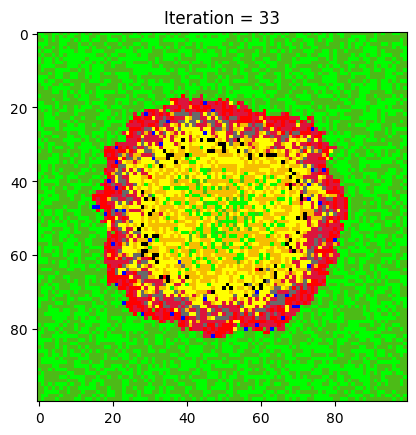

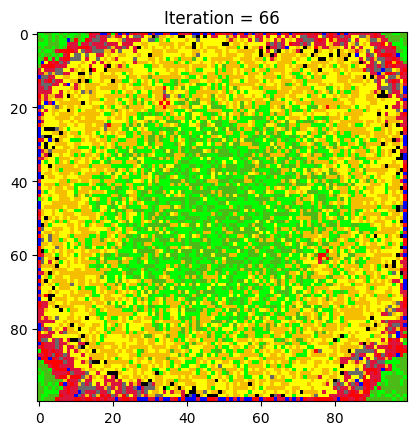

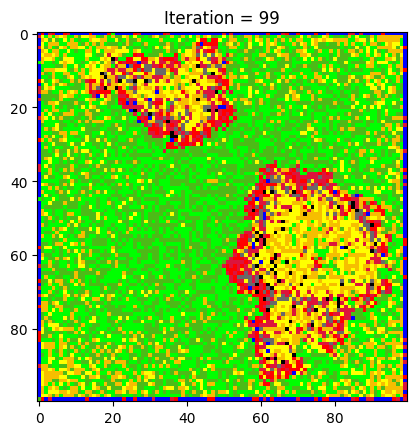

In [ ]:

N = 100
T = 100

tree1_dist = 0.5

tree1_BURN_TIME, tree1_GROW_TIME = 2, 5
tree2_BURN_TIME, tree2_GROW_TIME = 10, 15

FIRE_SPREAD_PROB = 0.3
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        tree1_BURN_TIME = tree1_BURN_TIME,
        tree1_GROW_TIME = tree1_GROW_TIME,
        tree2_BURN_TIME = tree2_BURN_TIME,
        tree2_GROW_TIME = tree2_GROW_TIME,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

### Verification 3: Tree 1 high BT, low GT

  0%|          | 0/100 [00:00<?, ?it/s]

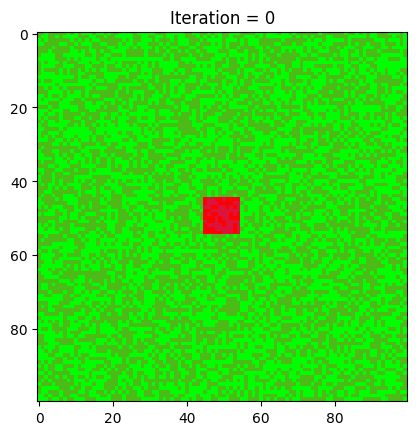

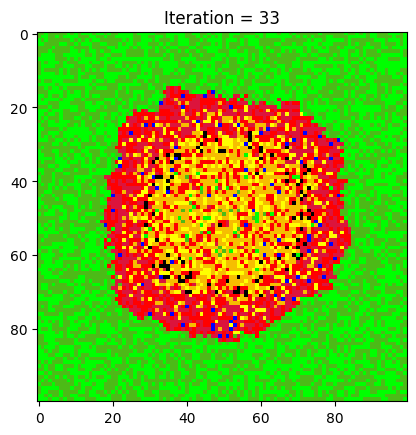

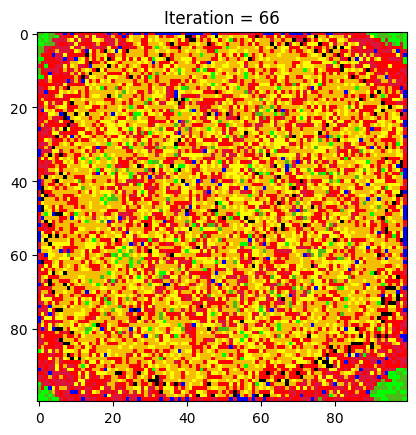

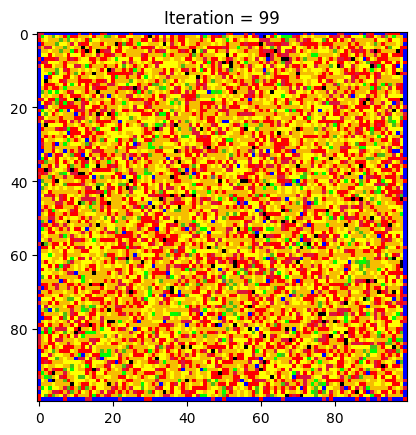

In [ ]:

N = 100
T = 100

tree1_dist = 0.5

tree1_BURN_TIME, tree1_GROW_TIME = 80, 5
tree2_BURN_TIME, tree2_GROW_TIME = 10, 15

FIRE_SPREAD_PROB = 0.3
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        tree1_BURN_TIME = tree1_BURN_TIME,
        tree1_GROW_TIME = tree1_GROW_TIME,
        tree2_BURN_TIME = tree2_BURN_TIME,
        tree2_GROW_TIME = tree2_GROW_TIME,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

### Verification 4: Tree 1 low BT, high **GT**

  0%|          | 0/100 [00:00<?, ?it/s]

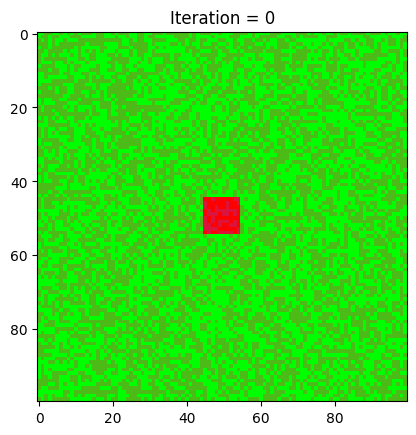

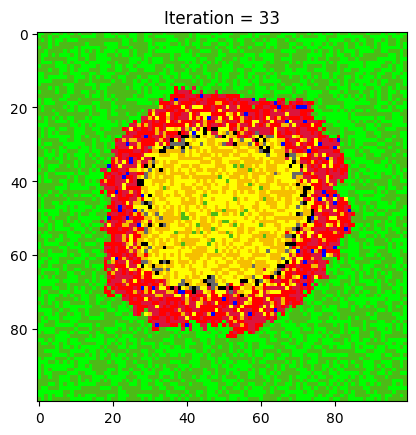

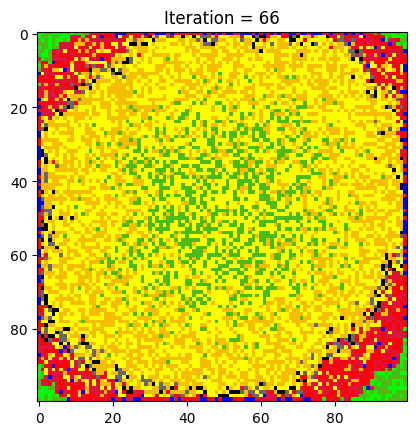

SystemError: ignored

In [ ]:

N = 100
T = 100

tree1_dist = 0.5

tree1_BURN_TIME, tree1_GROW_TIME = 10, 100
tree2_BURN_TIME, tree2_GROW_TIME = 10, 15

FIRE_SPREAD_PROB = 0.3
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

WATER_FRACTION = 0.04
WATER_RESOURCE = 0.02

IC_MODE = 2

plot_steps = [0, int(T/3), int(2*T/3), T-1]

experiment = True

sim = simulateStochasticFire(
        N = N ,
        tree1_dist = tree1_dist,
        tree1_BURN_TIME = tree1_BURN_TIME,
        tree1_GROW_TIME = tree1_GROW_TIME,
        tree2_BURN_TIME = tree2_BURN_TIME,
        tree2_GROW_TIME = tree2_GROW_TIME,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        WATER_FRACTION = WATER_FRACTION, 
        WATER_RESOURCE = WATER_RESOURCE,
        IC_MODE = IC_MODE,
        experiment = experiment
        )

# ani = sim.animate_forest(T=T)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

sim.run(T, plot_steps)

In [ ]:
plt.plot(sim.burnt_proportion)